In [1]:
# Author: James Meehan
# Date: 8/15/2018
# Description: Machine Learning Model to Predict Fantasy Scores for NFL Kickers on a weekly basis
# Cepheus Group Capstone

# import libraries
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
from sklearn import preprocessing

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# read the data, split into data stack, labels, and actual scores
df = pd.read_csv('KickerRev2.csv', sep=',', )
pts_targets = df
labels = df

labels = labels.loc[0:, 'fname':'actual']
labels = labels.values

df = df.loc[0:, 'rating':'gt50_2wk']
pts_targets = pts_targets.loc[0:, 'actual']

df = df.values
df.shape

(1628, 24)

In [3]:
# normalize the inputs
scaled_inputs = preprocessing.scale(df)
print(scaled_inputs)

samples_count = scaled_inputs.shape[0]

# split into training and test samples (80% training / 20% testing)
train_samples = int(0.8*samples_count)
test_samples = int(samples_count - train_samples)

train_inputs = scaled_inputs[:train_samples]
train_targets = pts_targets[:train_samples]

test_inputs = scaled_inputs[train_samples:]
test_targets = pts_targets[train_samples:]

[[-1.19164679 -1.00369232  1.032631   ... -0.73755358 -0.54793021
  -0.45641626]
 [-1.19164679  0.99632126 -0.75492799 ... -1.4889536  -1.34509767
  -0.45641626]
 [-1.19164679 -1.00369232 -0.100943   ...  0.76524645  1.0464047
   4.0468908 ]
 ...
 [ 0.59106422  0.99632126  1.81741299 ...  0.76524645  1.0464047
  -0.45641626]
 [ 1.55098554  0.99632126  0.858235   ...  2.26804649  1.0464047
  -0.45641626]
 [ 0.31680099  0.99632126 -2.89127898 ... -1.4889536  -1.34509767
  -0.45641626]]


In [4]:
print("Training set: {}".format(train_inputs.shape))  # 1322 examples, 24 features
print("Testing set:  {}".format(test_inputs.shape))   # 331 examples, 24 features

Training set: (1302, 24)
Testing set:  (326, 24)


In [6]:
# build the neural network.  Testing and refining found that a neural net with 1 hidden layer and 20 neurons 
# produced the best results.
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(20, activation=tf.nn.relu, 
                       input_shape=(train_inputs.shape[1],)),
  # keras.layers.Dense(20, activation=tf.nn.relu),
  # keras.layers.Dense(30, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])
  #AdamOptimizer
  optimizer = tf.train.AdamOptimizer(0.002)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                500       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 50

# Store training stats
history = model.fit(train_inputs, train_targets, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


..................................................

In [8]:
# graph training
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0,5])

plot_history(history)

In [9]:
# calculate performance
[loss, mae] = model.evaluate(test_inputs, test_targets, verbose=0)

print("Testing set Mean Abs Error: {:7.2f}".format(mae))
print("Testing set Mean Squared Error: {:7.2f}".format(loss))

Testing set Mean Abs Error:    3.66
Testing set Mean Squared Error:   21.02


In [10]:
# get predictions
test_predictions = model.predict(test_inputs).flatten()

print(test_predictions)

[10.135869   9.004758   8.414278   6.8782525  7.9274     8.678121
  6.4939117  6.5230308  7.407828   7.5327573  8.590121  10.75826
  8.02847    6.182019   7.797891   5.291997   7.0340676  6.804084
  7.600503   6.777062   5.570703   7.7436724  9.531674   8.922256
  6.724939   7.8399696  7.4330425 11.278372   9.445195   6.586544
  7.506295   8.051881   7.270205  10.0316925  8.290883   9.521759
  7.0133805  7.7340207  8.448604   8.3982315  6.36315    4.9164677
  7.8325143  6.54686    8.087456   8.678443   8.446426   5.682654
  9.994584  10.155743   9.947879  10.893993   6.950694   7.0206075
  8.9351845  7.9526954 10.118377  10.569193   6.938173   6.1224847
  7.22481   11.620803   8.789596   5.5050178  8.337113   5.0759478
  7.5438523  8.562365   8.1369     7.737291   8.926476  11.046231
  8.317537   7.639027   9.290113   8.993578   6.7107344  6.991578
  7.2648115  7.4502263  8.018831   6.5599127  7.162906  11.689824
  8.044573   8.03203    7.151799   8.449964   7.7316    11.585294
  7.302

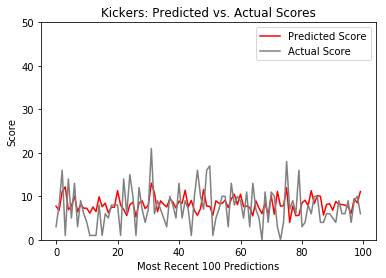

In [12]:
# graph predicted vs. actual scores
def plot_predict():
  plt.figure()
  plt.title('Kickers: Predicted vs. Actual Scores')
  plt.xlabel('Most Recent 100 Predictions')
  plt.ylabel('Score')
  plt.plot(np.array(test_predictions[226:326]), label = "Predicted Score",color="red")
  plt.plot(np.array(test_targets[226:326]), label = "Actual Score", color="grey")
  plt.legend()
  plt.ylim([0,50])

plot_predict()

In [13]:
Ktest_labels = labels[train_samples:]

In [14]:
print(test_predictions)

[10.135869   9.004758   8.414278   6.8782525  7.9274     8.678121
  6.4939117  6.5230308  7.407828   7.5327573  8.590121  10.75826
  8.02847    6.182019   7.797891   5.291997   7.0340676  6.804084
  7.600503   6.777062   5.570703   7.7436724  9.531674   8.922256
  6.724939   7.8399696  7.4330425 11.278372   9.445195   6.586544
  7.506295   8.051881   7.270205  10.0316925  8.290883   9.521759
  7.0133805  7.7340207  8.448604   8.3982315  6.36315    4.9164677
  7.8325143  6.54686    8.087456   8.678443   8.446426   5.682654
  9.994584  10.155743   9.947879  10.893993   6.950694   7.0206075
  8.9351845  7.9526954 10.118377  10.569193   6.938173   6.1224847
  7.22481   11.620803   8.789596   5.5050178  8.337113   5.0759478
  7.5438523  8.562365   8.1369     7.737291   8.926476  11.046231
  8.317537   7.639027   9.290113   8.993578   6.7107344  6.991578
  7.2648115  7.4502263  8.018831   6.5599127  7.162906  11.689824
  8.044573   8.03203    7.151799   8.449964   7.7316    11.585294
  7.302

In [15]:
fullList = []

for i in range(len(test_predictions)):
    mylist = []
    mylist.append(Ktest_labels[i][0])
    mylist.append(Ktest_labels[i][1])
    mylist.append(Ktest_labels[i][2])
    mylist.append(Ktest_labels[i][3])
    mylist.append(Ktest_labels[i][4])
    mylist.append(test_predictions[i])
    fullList.append(mylist)
print (fullList)

[[' Robbie', ' Gould', 4, 2017, 15, 10.135869], [' Stephen', ' Hauschka', 4, 2017, 15, 9.004758], [' Dustin', ' Hopkins', 4, 2017, 8, 8.414278], [' Wil', ' Lutz', 4, 2017, 8, 6.8782525], [' Brandon', ' McManus', 4, 2017, 10, 7.9274], [' Matt', ' Prater', 4, 2017, 6, 8.678121], [' Aldrick', ' Rosas', 4, 2017, 5, 6.4939117], [' Ryan', ' Succop', 4, 2017, 2, 6.5230308], [' Giorgio', ' Tavecchio', 4, 2017, 4, 7.407828], [' Justin', ' Tucker', 4, 2017, 3, 7.5327573], [' Adam', ' Vinatieri', 4, 2017, 4, 8.590121], [' Blair', ' Walsh', 4, 2017, 8, 10.75826], [' Greg', ' Zuerlein', 4, 2017, 23, 8.02847], [' Dan', ' Bailey', 5, 2017, 7, 6.182019], [' Connor', ' Barth', 5, 2017, 1, 7.797891], [' Chris', ' Boswell', 5, 2017, 9, 5.291997], [' Randy', ' Bullock', 5, 2017, 8, 7.0340676], [' Harrison', ' Butker', 5, 2017, 18, 6.804084], [' Chandler', ' Catanzaro', 5, 2017, 7, 7.600503], [' Mason', ' Crosby', 5, 2017, 5, 6.777062], [' Phil', ' Dawson', 5, 2017, 1, 5.570703], [' Jake', ' Elliott', 5, 2

In [16]:
import csv
from pandas import read_csv 

with open("KtestOutput.csv","w",newline="") as newFile: 
    cw = csv.writer(newFile, delimiter=',')
    for i in fullList:
        cw.writerow(i)
        
Kformat = read_csv('KtestOutput.csv', sep=',')
Kformat.columns = ['fname', 'lname', 'week', 'yr', 'actual', 'predicted']
        
Kformat.to_csv('KtestOutput.csv', index=False)

In [17]:
import psycopg2
conn = psycopg2.connect(database="Cepheus_db",
                        user="db_usr",
                        password="B3av3rs1!",
                        host="osucepheus.cgwruhobay1w.us-east-2.rds.amazonaws.com",
                        port="5432")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [18]:
#Create cursor with which to execute queries
cur = conn.cursor()

In [19]:
#parse csv
with open ('KtestOutput.csv') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        #build query string
        query1 = 'INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES '
        query2 =row['fname'], row['lname'], row['week'], row['yr'], row['actual'], row['predicted']
        query = str(query1) + str(query2)
        print(query)
        #execute query
        cur.execute(query)
#commit change
conn.commit()

INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Stephen', ' Hauschka', '4', '2017', '15', '9.004758')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Dustin', ' Hopkins', '4', '2017', '8', '8.414278')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Wil', ' Lutz', '4', '2017', '8', '6.878252499999999')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Brandon', ' McManus', '4', '2017', '10', '7.9274')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Matt', ' Prater', '4', '2017', '6', '8.678121')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Aldrick', ' Rosas', '4', '2017', '5', '6.4939117')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Ryan', ' Succop', '4', '2017', '2', '6.5230308')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Gi

INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Phil', ' Dawson', '13', '2017', '6', '5.503754')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Jake', ' Elliott', '13', '2017', '4', '5.46159')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Kaimi', ' Fairbairn', '13', '2017', '7', '8.236292')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Kai', ' Forbath', '13', '2017', '2', '7.180320299999999')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Graham', ' Gano', '13', '2017', '3', '7.599170699999999')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Zane', ' Gonzalez', '13', '2017', '4', '5.466007')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Stephen', ' Gostkowski', '13', '2017', '13', '6.948513')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predic

In [21]:
# import training data
training_predictions = model.predict(train_inputs).flatten()
#training_predictions.shape
print(training_predictions[1301])
print(labels[1301])

7.430948
[' Stephen' ' Gostkowski' 4 2017 14]


In [22]:
trainList = []

for i in range(447, 1301):
    mylist = []
    mylist.append(labels[i][0])
    mylist.append(labels[i][1])
    mylist.append(labels[i][2])
    mylist.append(labels[i][3])
    mylist.append(labels[i][4])
    mylist.append(training_predictions[i])
    trainList.append(mylist)
print (trainList)

[[' Dan', ' Bailey', 3, 2015, 4, 9.345733], [' Josh', ' Brown', 3, 2015, 12, 7.7441225], [' Matt', ' Bryant', 3, 2015, 7, 8.081267], [' Randy', ' Bullock', 3, 2015, 7, 6.1567936], [' Dan', ' Carpenter', 3, 2015, 13, 8.013056], [' Chandler', ' Catanzaro', 3, 2015, 9, 8.738982], [' Travis', ' Coons', 3, 2015, 8, 7.6039863], [' Mason', ' Crosby', 3, 2015, 8, 7.576588], [' Phil', ' Dawson', 3, 2015, 1, 5.378045], [' Nick', ' Folk', 3, 2015, 7, 7.0192018], [' Andrew', ' Franks', 3, 2015, 0, 5.8792024], [' Graham', ' Gano', 3, 2015, 9, 8.344634], [' Stephen', ' Gostkowski', 3, 2015, 15, 10.624396], [' Stephen', ' Hauschka', 3, 2015, 14, 8.75662], [' Dustin', ' Hopkins', 3, 2015, 7, 5.7466865], [' Sebastian', ' Janikowski', 3, 2015, 9, 6.1231236], [' Josh', ' Lambo', 3, 2015, 2, 5.7921634], [' Brandon', ' McManus', 3, 2015, 6, 6.192695], [' Jason', ' Myers', 3, 2015, 5, 4.8249226], [' Mike', ' Nugent', 3, 2015, 4, 6.0613985], [' Matt', ' Prater', 3, 2015, 0, 4.8597307], [' Cairo', ' Santos', 

In [23]:
import csv
from pandas import read_csv 

with open("KtrainOutput.csv","w",newline="") as newFile: 
    cw = csv.writer(newFile, delimiter=',')
    for i in trainList:
        cw.writerow(i)
        
Kformat = read_csv('KtrainOutput.csv', sep=',')
Kformat.columns = ['fname', 'lname', 'week', 'yr', 'actual', 'predicted']
        
Kformat.to_csv('KtrainOutput.csv', index=False)

In [24]:
# put training predict data into database
#Create cursor with which to execute queries
cur = conn.cursor()

#parse csv
with open ('KtrainOutput.csv') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        #build query string
        query1 = 'INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES '
        query2 =row['fname'], row['lname'], row['week'], row['yr'], row['actual'], row['predicted']
        query = str(query1) + str(query2)
        print(query)
        #execute query
        cur.execute(query)
#commit change
conn.commit()


INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Josh', ' Brown', '3', '2015', '12', '7.7441225000000005')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Matt', ' Bryant', '3', '2015', '7', '8.081267')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Randy', ' Bullock', '3', '2015', '7', '6.156793599999999')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Dan', ' Carpenter', '3', '2015', '13', '8.013056')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Chandler', ' Catanzaro', '3', '2015', '9', '8.738982')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Travis', ' Coons', '3', '2015', '8', '7.6039863')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Mason', ' Crosby', '3', '2015', '8', '7.576588')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) 

INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Andrew', ' Franks', '10', '2015', '8', '5.840056')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Graham', ' Gano', '10', '2015', '9', '8.673697')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Stephen', ' Gostkowski', '10', '2015', '11', '8.369957000000001')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Robbie', ' Gould', '10', '2015', '13', '6.900372999999999')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Dustin', ' Hopkins', '10', '2015', '17', '8.557822999999999')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Sebastian', ' Janikowski', '10', '2015', '2', '7.1435122')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Brandon', ' McManus', '10', '2015', '1', '8.065625')
INSERT INTO kicker_results(fname, lname,

INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Travis', ' Coons', '16', '2015', '7', '5.630886')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Phil', ' Dawson', '16', '2015', '5', '7.255839')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Kai', ' Forbath', '16', '2015', '8', '7.655261500000001')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Andrew', ' Franks', '16', '2015', '6', '7.820597')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Graham', ' Gano', '16', '2015', '7', '7.715856')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Stephen', ' Gostkowski', '16', '2015', '8', '9.959878')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Robbie', ' Gould', '16', '2015', '16', '9.249535')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES

INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Sebastian', ' Janikowski', '7', '2016', '17', '7.855299499999999')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Josh', ' Lambo', '7', '2016', '15', '6.7915606')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Wil', ' Lutz', '7', '2016', '3', '7.2080720000000005')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Brandon', ' McManus', '7', '2016', '9', '9.323875')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Jason', ' Myers', '7', '2016', '10', '7.4288487000000005')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Nick', ' Novak', '7', '2016', '9', '5.015429')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Mike', ' Nugent', '7', '2016', '7', '6.5102096')
INSERT INTO kicker_results(fname, lname, week, yr, actual, pre

INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Phil', ' Dawson', '15', '2016', '1', '7.718564999999999')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Nick', ' Folk', '15', '2016', '7', '6.2663126')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Kai', ' Forbath', '15', '2016', '8', '8.952588')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Andrew', ' Franks', '15', '2016', '4', '7.940404400000001')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Graham', ' Gano', '15', '2016', '14', '8.668624000000001')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Stephen', ' Gostkowski', '15', '2016', '10', '8.329991')
INSERT INTO kicker_results(fname, lname, week, yr, actual, predicted) VALUES (' Robbie', ' Gould', '15', '2016', '5', '11.711497999999999')
INSERT INTO kicker_results(fname, lname, week, yr